<a href="https://colab.research.google.com/github/gverafei/scraping/blob/main/scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Investigating how to scrape the web**
April 2025

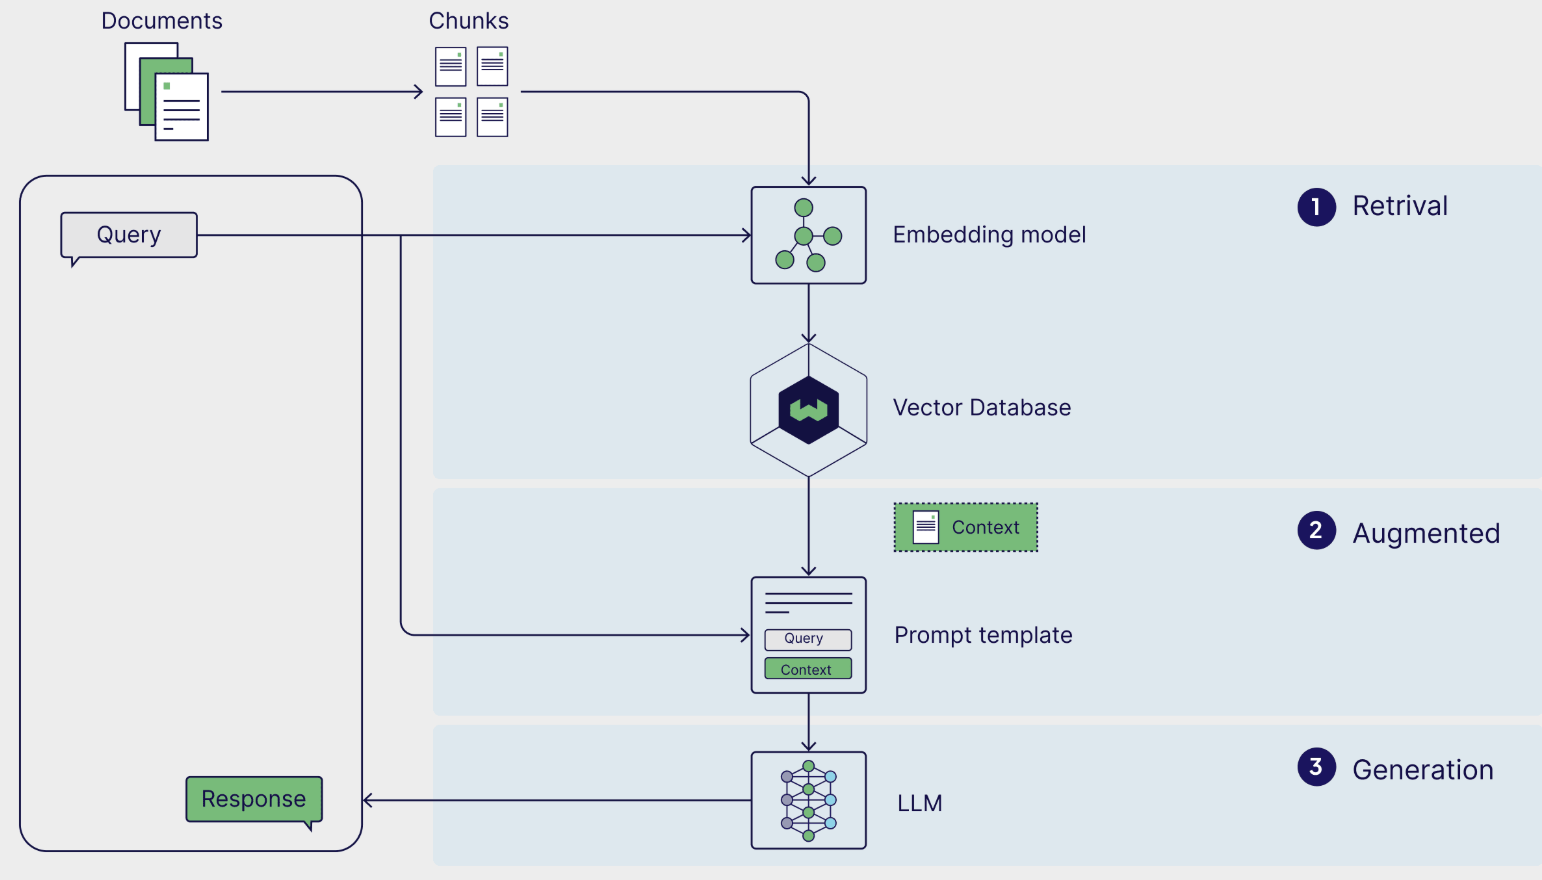

## Configure virtual environment

Solo se ejecuta lo siguiente la primera vez. Pedirá seleccionar the kernel from the upper right corner. Choose this virtual environment we just created.

In [47]:
# !python3 -m venv .venv
# !source .venv/bin/activate # Linux/Mac
# !.\venv\Scripts\activate # Windows

Inicializa el repositorio en GitHub. Todo esto se hace desde la terminal.

In [48]:
# !git init
# !git remote add origin https://github.com/gverafei/scraping.git
# !git pull origin main
# git add .
# git commit -m "Initial commit"
# git push --set-upstream origin main

In [49]:
!pip install --upgrade pip --quiet

## Create the initial data

In [50]:
competitor_sites = [
    # {
    #     "name": "Amazon",
    #     "url": "https://www.amazon.com"
    # },
    # {
    #     "name": "UV",
    #     "url": "https://www.uv.mx"
    # },
    # {
    #     "name": "W3C ACT Rules",
    #     "url": "https://www.w3.org/WAI/standards-guidelines/act/rules/"
    # },
    # {
    #     "name": "Chedrahui",
    #     "url": "https://www.chedraui.com.mx"
    # },
    # {
    #     "name": "FEI",
    #     "url": "https://www.uv.mx/fei/"
    # },
    {
        "name": "Sistemas FEI",
        "url": "https://sistemasfei.uv.mx/inicio/"
    }
]

## Setup cost's calculations

The idea is to compare side-by-side.

We can calculate how much it'll cost by using OpenAI's `tiktoken` library from: https://github.com/openai/tiktoken

And costs from: https://openai.com/api/pricing/

In [51]:
!pip install tiktoken --quiet

In [52]:
import tiktoken

def count_tokens(input_string: str) -> int:
    encoder = tiktoken.encoding_for_model("gpt-4o")
    tokens = encoder.encode(input_string)
    return len(tokens)

def calculate_cost(input_string: str, cost_per_million_tokens: float = 2.5) -> tuple:
    num_tokens = count_tokens(input_string)
    total_cost = (num_tokens / 1_000_000) * cost_per_million_tokens
    return total_cost, num_tokens

def calculate_cost_tokens(num_tokens: int, cost_per_million_tokens: float = 2.5) -> float:
    total_cost = (num_tokens / 1_000_000) * cost_per_million_tokens
    return total_cost

# Example usage:
# input_string = "Porque la gallina cruzó el camino? Pues porque quería llegar al otro lado."
# cost = calculate_cost(input_string)
# print(f"The total cost for using gpt-4o is: $US {cost:.6f}")

## Table para ver los resultados

Ahora, para ver los resultados de la comparaciones, instalamos un paquete para ver tablas en línea de comandos: https://pypi.org/project/prettytable/

Y también instalamos un paquete para ver una barra de progreso bonita en loops: https://pypi.org/project/tqdm/

In [53]:
!pip install prettytable --quiet

In [54]:
!pip install tqdm --quiet

In [55]:
from typing import List, Callable, Dict
from prettytable import PrettyTable
from tqdm import tqdm

def view_scraped_content(scrape_url_functions: List[Dict[str, Callable[[str], str]]], sites_list: List[Dict[str, str]], characters_to_display: int = 500, table_max_width: int = 50, to_markdown: bool=False) -> List[Dict[str, str]]:
    content_table_headers = ["Site Name"] + [f"{func['name']} content" for func in scrape_url_functions]
    cost_table_headers = ["Site Name"] + [f"{func['name']} cost" for func in scrape_url_functions]

    content_table = PrettyTable()
    content_table.field_names = content_table_headers

    cost_table = PrettyTable()
    cost_table.field_names = cost_table_headers

    scraped_data = []

    for site in sites_list:
        content_row = [site['name']]
        cost_row = [site['name']]
        site_data = {"provider": site['name'], "sites": []}

        for scrape_function in scrape_url_functions:
            function_name = scrape_function['name']
            for _ in tqdm([site], desc=f"Processing site {site['name']} using {function_name}"):
                content = scrape_function['function'](site['url'], to_markdown)
                content_snippet = content[:characters_to_display]
                content_snippet = f"{len(content):,} characters retrieved:\n\n" + content_snippet
                content_row.append(content_snippet)

                cost, count_tokens = calculate_cost(content)
                cost_row.append(f"${cost:.6f} (tokens: {count_tokens:,})")

                site_data["sites"].append({"name": function_name, "content": content})

        content_table.add_row(content_row)
        cost_table.add_row(cost_row)
        scraped_data.append(site_data)

    content_table.max_width = table_max_width
    content_table.hrules = True

    cost_table.max_width = table_max_width
    cost_table.hrules = True

    print("Content Table:")
    print(content_table)

    print("\nCost Table:\nThis is how much it would cost to use gpt-4o to use this content as input.")
    print(cost_table)

    return scraped_data

## Setup all the scrapers

Let's setup all of our scrapers.

## Beautiful Soup

Se instala este paquete desde: https://pypi.org/project/beautifulsoup4/

Y también request para hacer peticiones desde: https://pypi.org/project/requests/

In [56]:
!pip install requests beautifulsoup4 --quiet

In [57]:
!pip install markdownify --quiet

In [58]:
# Beautiful Soup utility functions

import requests
from bs4 import BeautifulSoup
from markdownify import markdownify as md

def beautiful_soup_scrape_url(url: str, to_markdown: bool = False) -> str:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    if to_markdown:
        return md(str(soup)) # Convert to markdown
    return str(soup)

## Playwright

La manera clásica de hacer scraping. No es especial para LLMs desde: https://playwright.dev/

In [59]:
!pip install playwright --quiet

In [60]:
!playwright install

In [61]:
!pip install nest_asyncio --quiet

In [62]:
!pip install markdownify --quiet

In [63]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from playwright.async_api import async_playwright

async def scrape_playwright(url: str, to_markdown: bool = False) -> str:
    async with async_playwright() as pw:
        browser =  await pw.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.goto(url)
        # Espera para que cargue la pagina
        await page.wait_for_load_state('domcontentloaded')
        # Ejecuta un script para bajar hasta el final de la pagina
        # await page.evaluate('window.scrollTo(0, document.body.scrollHeight)')
        # Tambien se puede hacer con el teclado
        await page.keyboard.press('End')
        # Espera a que baje el scroll
        await page.wait_for_timeout(2000)

        html = await page.content()
        if to_markdown:
            html = md(html) # Convert to markdown
        
        await browser.close()
        return html

def scrape_playwright_sync(url: str, to_markdown: bool = False):
    return asyncio.run(scrape_playwright(url, to_markdown))

# print(scrape_playwright_sync("https://www.amazon.com", to_markdown=True))

## Reader API by Jina AI

Este es especialmente para LLMs también. Setup Jina AI's scrape method from: https://jina.ai/reader/

In [64]:
import requests

def scrape_jina_ai(url: str, to_markdown: bool = False) -> str:
    headers = {
        'X-Return-Format': 'markdown' if to_markdown else 'html',
        'X-Engine': 'browser',
        'X-Timeout': '30',
        "X-With-Images-Summary": "none" if to_markdown else "all",
    }
    data = {
        'url': url,
        'injectPageScript': [
            'document.addEventListener("mutationIdle", window.simulateScroll);'
        ]
    }
    response = requests.post('https://r.jina.ai/', headers=headers, json=data)
    return response.text

# print(scrape_jina_ai("https://www.uv.mx", to_markdown = True))

## Crawl4AI: Open-Source LLM-Friendly Web Crawler & Scraper

Este es especialmente para obtener formato amigable para LLMs desde: https://docs.crawl4ai.com/

Primero instalamos prerequisitos que requiere Google Colab.

In [65]:
!pip install h5py --quiet

In [66]:
!pip install typing-extensions --quiet

In [67]:
!pip install wheel --quiet

Posteriormente, ya podemos realizar la instalación.

In [68]:
!pip install crawl4ai --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 4.44.1 requires aiofiles<24.0,>=22.0, but you have aiofiles 24.1.0 which is incompatible.


In [69]:
!crawl4ai-setup

[INIT].... → Running post-installation setup...
[INIT].... → Installing Playwright browsers...
[COMPLETE] ● Playwright installation completed successfully.
[INIT].... → Starting database initialization...
[COMPLETE] ● Database initialization completed successfully.
[COMPLETE] ● Post-installation setup completed!


In [70]:
!pip install nest_asyncio --quiet

In [71]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from crawl4ai import AsyncWebCrawler
from crawl4ai.async_configs import BrowserConfig, CrawlerRunConfig

browser_conf = BrowserConfig(verbose=False,headless=True)

run_cfg = CrawlerRunConfig(
    wait_until="domcontentloaded",
    wait_for_images=True,
    scan_full_page=True,
    verbose=False,
)

async def async_scrape_crawl4ai(url: str, to_markdown: bool = False) -> str:
    crawler = AsyncWebCrawler(config=browser_conf)
    await crawler.start()
    result = await crawler.arun(
        url=url,
        config=run_cfg,
    )

    if not to_markdown:
        return result.html
    
    # Convert HTML to Markdown
    # Get all the images
    images = result.media.get("images", [])
    images_list = f"\n\nImages found:{len(images)}"
    for i, img in enumerate(images):
        images_list = images_list + f"\n - ![Image {i+1}: {img.get('alt','No description')}]({img.get('src','')})"
        # Example: - ![Image 1: Alt text](https://example.com/image1.jpg)
    
    return result.markdown + images_list

# To run the async function in a synchronous context
# (like this script), you can use asyncio.run() to execute it.
# This is a workaround for running async functions in a sync context.
def scrape_crawl4ai(url: str, to_markdown: bool = False):
    return asyncio.run(async_scrape_crawl4ai(url, to_markdown))

# print(scrape_crawl4ai("https://www.uv.mx", to_markdown=True))

## Firecrawl: Turn websites into LLM-ready data

Esta es otra opción que no se usará porque tiene costo. También esta enfocado en AI. Desde: https://www.firecrawl.dev/

## Main functions to run the comparasion with HTML

Let's run all the scrapers and display them in our comparison table.

In [72]:
list_of_scraper_functions = [
      {"name": "Beautiful Soup", "function": beautiful_soup_scrape_url},
      # {"name": "Jina AI", "function": scrape_jina_ai},
      # {"name": "Playwright", "function": scrape_playwright_sync},
      {"name": "Crawl4ai", "function": scrape_crawl4ai},
      ]

all_content_html = view_scraped_content(list_of_scraper_functions, competitor_sites, 800, 35, to_markdown=False)

Processing site Sistemas FEI using Beautiful Soup: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
Processing site Sistemas FEI using Crawl4ai:   0%|          | 0/1 [00:00<?, ?it/s]


Exception: BrowserType.launch: Connection closed while reading from the driver

## Realizamos la comparación con markdown

Vamos a ejecutar todos los scrapers pero ahora que devuelvan un formato más amigable para la IA.

In [ ]:
all_content_md = view_scraped_content(list_of_scraper_functions, competitor_sites, 1200, 35, to_markdown=True)

Processing site Sistemas FEI using Beautiful Soup: 100%|██████████| 1/1 [00:00<00:00, 25.74it/s]
Processing site Sistemas FEI using Crawl4ai: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Content Table:
+--------------+-------------------------------------+-------------------------------------+
|  Site Name   |        Beautiful Soup content       |           Crawl4ai content          |
+--------------+-------------------------------------+-------------------------------------+
| Sistemas FEI |     1,345 characters retrieved:     |     2,064 characters retrieved:     |
|              |                                     |                                     |
|              |             Sistemas FEI            | [ ![Logo FEI](https://sistemasfei.u |
|              |                                     | v.mx/inicio/_astro/logoFEI.CKAzzJnF |
|              |                                     |            _ZyfpCW.webp)            |
|              |                                     |       ](http://www.uv.mx/fei)       |
|              |                                     |       # Portal de sistemas FEI      |
|              | [![Logo FEI](_astro/logoFEI.CKAzzJn | 

## Conectar con OpenAI para enviar la información

Vamos a enviar el contenido en HTML y en markdown y le vamos a pedir que nos devuelva una sección accesible WCAG 2.2.

In [ ]:
!pip install openai --quiet

In [ ]:
import getpass
from openai import OpenAI

OPENAI_API_KEY = getpass.getpass('Enter your OpenAI API key: ')

client = OpenAI(api_key=OPENAI_API_KEY)

def extract(user_input: str, user_prompt: str, template: str = None) -> str:
    entity_extraction_system_message = {
        "role": "system", 
        "content": """"
        1. You are a helpful assistant expert on web accessibility WCAG that evaluate and correct HTML code.
        2. You will be given code and you will analize it.
        3. Then, you will create a new webpage from that code but accessible according to WCAG https://www.w3.org/WAI/WCAG22/Understanding/
        4. Check all rules including color contrast, alt text, and semantic HTML.
        5. Use absolute URLs for the images that have a relative ones.
        6. If you include an style.css file, you will add the rules inline in the head section.
        7. Also, you will provide a list of the procedure you did respect to the original in markdown format.
        8. Dont scape the HTML code, just return it as a string. For example don't add "\n" or \" to the HTML code.
        9. Return the result as a JSON with values: {Procedure: str, HTML: str}
        """
    }
    # Add the system message to the messages list
    messages = [entity_extraction_system_message]
    # Add the content to the messages list
    messages.append({"role": "user", "content": user_prompt})
    messages.append({"role": "user", "content": user_input})
    if template:
        messages.append({"role": "user", "content": "The following is a template as a base for the HTML code you will generate with the content. Use bootstrap classes to make it responsive and accessible. " + template})
        messages.append({"role": "user", "content": template})
    # Call the OpenAI API to get the response
    response = client.chat.completions.create(
        model="gpt-4o",
        stream=False,
        messages=messages,
        response_format={"type": "json_object"},
    )
    
    # return response.choices[0].message.content
    return response.choices[0].message.content, response.usage.completion_tokens, response.usage.prompt_tokens

## Comparar los resultados

Ahora se crearemos una función para crear una tabla con los resultados de comparar el resultado devuelto en HTML y en Markdown. 

In [ ]:
def display_extracted_content(results_html: List[Dict[str, any]], results_md: List[Dict[str, any]], function_name: str):
    table = PrettyTable()
    table.field_names = ["Site", "From HTML", "From markdown", "From markdown with template"]

    with open('templates/tem001.html', 'r') as file:  # r to open file in READ mode
        html_as_string = file.read()

    # Iterate through each site and its content
    for i,result in tqdm(enumerate(results_html), desc="Processing results"):
        sites_html = results_html[i]["sites"]
        sites_md = results_md[i]["sites"]
        provider = results_html[i]["provider"]

        for i in range(len(sites_html)):
            if sites_html[i]["name"] == function_name:
                # Extract the content for HTML and Markdown
                content_html = sites_html[i]["content"]
                content_md = sites_md[i]["content"]

                # Progress bar for each function
                for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for HTML input"):
                    extracted_content_html, completion_tokens, prompt_tokens = extract(content_html, "Use the following HTML code and create a new accessible web page version mantaining all the contents. The absolute URL is https://sistemasfei.uv.mx/inicio/")
                    cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                    cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost:${cost:.6f}" + "\n\n\n"
                    col_content_html = cost_label + extracted_content_html

                # Progress bar for each function
                for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for Markdown input"):
                    extracted_content_md, completion_tokens, prompt_tokens = extract(content_md, "Use the following content to create a new accessible web page version. Use the code from https://webaim.org/ as a base to create a new accessible web page version. Observe the structure of the header, the images are in on row with the title; also the use of cols and rows to make it responsive and accessible.", template=None)
                    cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                    cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost:${cost:.6f}" + "\n\n\n"
                    col_content_md = cost_label + extracted_content_md

                # Progress bar for each function
                for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for Markdown input and template"):
                    extracted_content_md_template, completion_tokens, prompt_tokens = extract(content_md, "Use the following content to create a new accessible web page version.",html_as_string.replace("\n",""))
                    cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                    cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost:${cost:.6f}" + "\n\n\n"
                    col_content_md_template = cost_label + extracted_content_md_template

                table.add_row([provider, col_content_html, col_content_md, col_content_md_template])

    table.max_width = 50  # Set the maximum width for better display
    table.hrules = True  # Add horizontal rules for better readability

    print("Extracted Content Table:")
    print(table)

    return extracted_content_html, extracted_content_md, extracted_content_md_template

In [ ]:
extracted_json_html, extracted_json_md, extracted_json_md_template = display_extracted_content(all_content_html, all_content_md, "Crawl4ai")

Processing results: 0it [00:00, ?it/s]
Extracting content with Crawl4ai for HTML input:   0%|          | 0/1 [00:00<?, ?it/s]
Extracting content with Crawl4ai for HTML input: 100%|██████████| 1/1 [00:21<00:00, 21.87s/it]

Extracting content with Crawl4ai for Markdown input:   0%|          | 0/1 [00:00<?, ?it/s]
Extracting content with Crawl4ai for Markdown input: 100%|██████████| 1/1 [00:15<00:00, 15.97s/it]

Extracting content with Crawl4ai for Markdown input and template:   0%|          | 0/1 [00:00<?, ?it/s]
Extracting content with Crawl4ai for Markdown input and template: 100%|██████████| 1/1 [00:20<00:00, 20.39s/it]
Processing results: 1it [00:58, 58.24s/it]


Extracted Content Table:
+--------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
|     Site     |                     From HTML                      |                   From markdown                    |            From markdown with template             |
+--------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| Sistemas FEI |              Completion tokens: 2,188              |              Completion tokens: 1,752              |              Completion tokens: 2,185              |
|              |                Prompt tokens: 3,158                |                Prompt tokens: 1,028                |                Prompt tokens: 2,251                |
|              |                Total cost:$0.013365                |                Total cost

## Visualizar los resultados obtenidos

Instalamos las dependencias necesarias para generar la interface web.

In [ ]:
!pip install aiofiles --quiet

In [ ]:
!pip install gradio --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
crawl4ai 0.5.0.post8 requires aiofiles>=24.1.0, but you have aiofiles 23.2.1 which is incompatible.


Obtenemos los resultados en un objeto JSON.

In [ ]:
import json
json_data_html = json.loads(extracted_json_html)
json_data_md = json.loads(extracted_json_md)
json_data_md_template = json.loads(extracted_json_md_template)

Creamos una función de apoyo para crear la interface web y poder ver los resultados visualmente.

In [ ]:
import gradio as gr

with gr.Blocks(theme=gr.themes.Default()) as demo:
    # From HTML
    with gr.Tab("Proc HTML"):
        gr.Markdown(json_data_html["Procedure"], label="Procedure")
    with gr.Tab("Code HTML"):
        gr.TextArea(json_data_html["HTML"], label="HTML code", show_copy_button=True, lines=20)
    with gr.Tab("Res HTML"):
        gr.HTML(json_data_html["HTML"])
    # From Markdown
    with gr.Tab("Proc MD"):
        gr.Markdown(json_data_md["Procedure"], label="Procedure")
    with gr.Tab("Code MD"):
        gr.TextArea(json_data_md["HTML"], label="HTML code", show_copy_button=True, lines=20)
    with gr.Tab("Res MD"):
        gr.HTML(json_data_md["HTML"])
    # From Markdown with template
    with gr.Tab("Proc MD with template"):
        gr.Markdown(json_data_md_template["Procedure"], label="Procedure")
    with gr.Tab("Code MD with template"):
        gr.TextArea(json_data_md_template["HTML"], label="HTML code", show_copy_button=True, lines=20)
    with gr.Tab("Res MD with template"):
        gr.HTML(json_data_md_template["HTML"])

demo.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [ ]:
# import os

# if not os.path.exists("output"):
#     os.makedirs("output")

# with open(f'output/from_html.html', "w+", encoding="utf-8") as f:
#     f.write(json_data_html["HTML"])

# with open(f'output/from_markdown.html', "w+", encoding="utf-8") as f:
#     f.write(json_data_md["HTML"])

# with open(f'output/from_markdown_template.html', "w+", encoding="utf-8") as f:
#     f.write(json_data_md_template["HTML"])

In [ ]:
!pip install flask --quiet

In [ ]:
from flask import Flask
app = Flask(__name__)

@app.route('/html')
def index_html():
    return json_data_html["HTML"]

@app.route('/md')
def index_mc():
    return json_data_md["HTML"]

@app.route('/template')
def index_template():
    return json_data_md_template["HTML"]

app.run(port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [01/Apr/2025 15:11:19] "GET /html HTTP/1.1" 200 -


From HTML: http://127.0.0.1:5000/html

From Markdown: http://127.0.0.1:5000/md

From Template: http://127.0.0.1:5000/template